In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [ ]:
DATA_ROOT = os.path.expanduser("../data")
TILE_DIR  = os.path.join(DATA_ROOT, "rubin_tiles_ecdfs")

files = sorted(glob.glob(os.path.join(TILE_DIR, "*.npz")))
print(len(files), files[:3])

f = np.load(files[0])
print(f.files)
img  = f["img"]  
bands = ["u", "g", "r", "i","z","y"]

fig, axs = plt.subplots(1, img.shape[0], figsize=(12,4))
for i, ax in enumerate(axs):
    lo, hi = np.percentile(img[i], (1,99))
    ax.imshow(img[i], origin="lower", vmin=lo, vmax=hi)
    ax.set_title(bands[i])
    ax.axis("off")
plt.show()


In [ ]:

import os, glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS

TILE_DIR = os.path.expanduser("../data/rubin_tiles_ecdfs_gr_i")
files = sorted(glob.glob(os.path.join(TILE_DIR, "*.npz")))
len(files), files[:3]

def wcs_from_npz_wcs_hdr(wcs_hdr):
    """
    wcs_hdr is stored as a dict in the NPZ. Turn it into an astropy.wcs.WCS.
    """
    # np.load gives object arrays sometimes; ensure plain dict
    if isinstance(wcs_hdr, np.ndarray) and wcs_hdr.dtype == object:
        wcs_hdr = wcs_hdr.item()
    return WCS(wcs_hdr)

def tile_footprint_radec(npz_path):
    z = np.load(npz_path, allow_pickle=True)
    img = z["img"]
    H, W = img.shape[-2], img.shape[-1]

    w = wcs_from_npz_wcs_hdr(z["wcs_hdr"])

    # pixel corners (0-indexed pixel coordinates in the cutout)
    # corners in order: (0,0) (W,0) (W,H) (0,H) and close polygon
    px = np.array([0, W, W, 0, 0], dtype=float)
    py = np.array([0, 0, H, H, 0], dtype=float)

    ra, dec = w.wcs_pix2world(px, py, 0)  # origin=0 for 0-indexed
    return ra, dec

    plt.figure(figsize=(8,8))

# If many tiles, plot a subset first
use = files[:200]  # adjust

for fp in use:
    ra, dec = tile_footprint_radec(fp)

    # RA wrap handling: for small fields it's usually fine, but this keeps it stable
    ra = np.unwrap(np.deg2rad(ra))
    ra = np.rad2deg(ra)

    plt.plot(ra, dec, lw=0.6, alpha=0.5)

plt.gca().invert_xaxis()  # standard sky convention: RA increases to the left
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.title("Tile footprints from NPZ WCS")
plt.show()



In [ ]:
class RubinTileDataset(Dataset):
    def __init__(self, tile_dir):
        self.files = sorted(glob.glob(os.path.join(tile_dir, "*.npz")))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        f = np.load(self.files[idx])
        img = torch.from_numpy(f["img"]).float()   # [B,H,W]
        var = torch.from_numpy(f["var"]).float()
        msk = torch.from_numpy(f["mask"]).long()
        return img, var, msk

ds = RubinTileDataset(TILE_DIR)
dl = DataLoader(ds, batch_size=2, shuffle=True, num_workers=2)

img, var, msk = next(iter(dl))
img.shape, var.shape, msk.shape


In [ ]:
class TinyConv(nn.Module):
    def __init__(self, in_ch=3, out_ch=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, out_ch, 3, padding=1),
        )

    def forward(self, x):
        return self.net(x)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = TinyConv().to(device)

img = img.to(device)
var = var.to(device)

out = model(img)
loss = (out**2).mean()   # dummy loss

loss.backward()
loss.item()



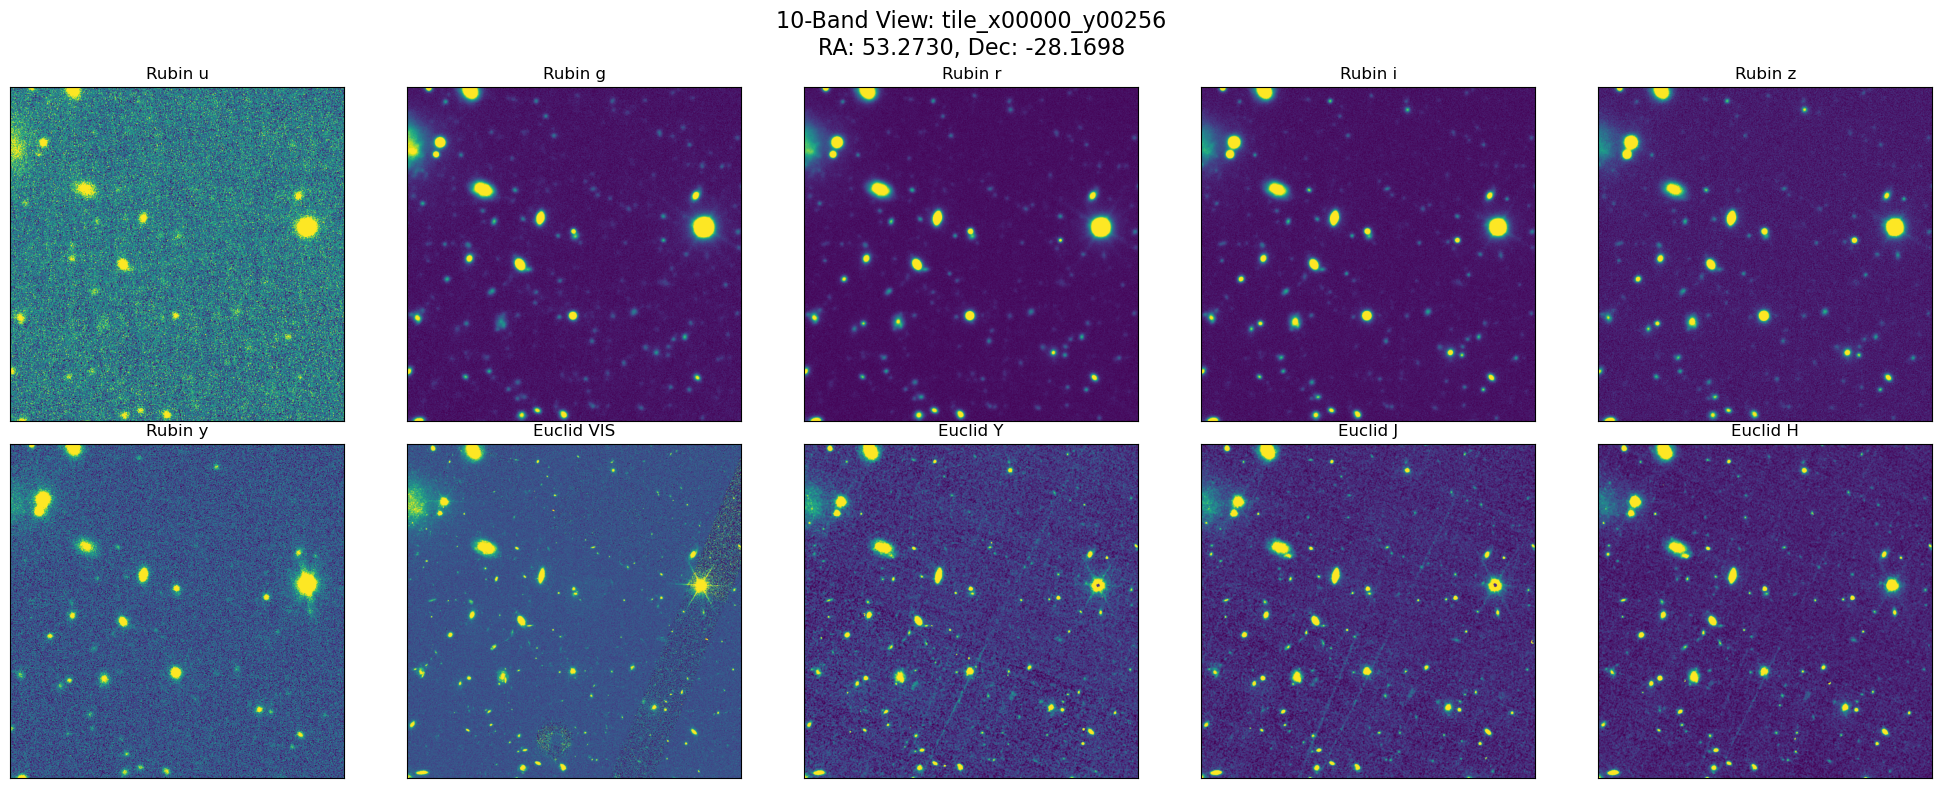

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS
def robust_imshow(ax, img, title="", p=(1, 99)):
    if img is None:
        ax.set_title(f"{title} (missing)")
        ax.axis("off")
        return
    lo, hi = np.nanpercentile(img, p)
    ax.imshow(img, origin="lower", vmin=lo, vmax=hi)
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
OUT_RUBIN_DIR = "../data/rubin_tiles_ecdfs"
OUT_EUCLID_DIR = "../data/euclid_tiles_ecdfs"

# ---- Path Configuration ----
tile_id_str = "tile_x00000_y00256"
rubin_path  = os.path.join(OUT_RUBIN_DIR,  f"{tile_id_str}.npz")
euclid_path = os.path.join(OUT_EUCLID_DIR, f"{tile_id_str}_euclid.npz")

# 1. Load Data
r_data = np.load(rubin_path)
e_data = np.load(euclid_path)

# Bands Mapping
# Rubin: u, g, r, i, z, y (indices 0-5)
# Euclid: VIS, Y, J, H
rubin_bands = ["u", "g", "r", "i", "z", "y"]
euclid_bands = ["VIS", "Y", "J", "H"]

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

# 2. Plot Rubin Bands (Top Row + 1st of Bottom)
for i, band in enumerate(rubin_bands):
    ax = axes[i]
    img = r_data['img'][i]
    robust_imshow(ax, img, title=f"Rubin {band}")

# 3. Plot Euclid Bands (Remaining 4 slots)
for i, band in enumerate(euclid_bands):
    ax = axes[i + 6] # Start at index 6
    img_key = f"img_{band}"
    
    if img_key in e_data:
        img = e_data[img_key]
        # We can also parse the WCS if needed:
        # wcs = WCS(e_data[f"wcs_{band}"]) 
        robust_imshow(ax, img, title=f"Euclid {band}")
    else:
        ax.set_title(f"Euclid {band} (Missing)")
        ax.axis('off')

plt.suptitle(f"10-Band View: {tile_id_str}\nRA: {r_data['ra_center']:.4f}, Dec: {r_data['dec_center']:.4f}", fontsize=16)
plt.tight_layout()
plt.show()